Author: Xiang Zhao magelead@outlook.com

TODO:
1. Qbsolv https://github.com/dwavesystems/qbsolv/ ✅
2. Include linear coefficients in diagonal of QUBO quadratic matrix ✅ 
3. implement figure 1 of paper && determine penalty factors
4. consider other constraints

In [ ]:
!pip install qiskit qiskit-optimization dwave-qbsolv

# Airbus challenge
References:

[1] https://arxiv.org/pdf/2102.09621.pdf

[2] https://github.com/magelead/QGSS-2021/blob/main/Lab%202/lab-2.ipynb

# Part I Setup the QUBO model

In [ ]:
import sympy as sym
import numpy as np

Problem 1: This problem's size is optimal for qiskit to simulate, so I solve it via a classical algorithm and a quantum algorithm.

In [ ]:
# Settings for a toy experiment correct solution 3

n=3
N=2
W=3 # max weight unit is 100kg
m=[2.0, 1.0, 3.0] # unit is 100kg, type 1 container, type 2 container, type 3 container
t=[1.0,1.0,0.5] # t[i] = 1 for type 1 or 2 container; 1/2 for type 3 container 
d=[1.0,0.5,1.0] # d[i] = 1 for type 1 or 3 container; 1/2 for type 2 container


K=n+N+2 # number of slack variables: K = n + N + number of bits of binary expansion of W

    
z=[sym.Symbol(f'z_{i}') for i in range(n*N+K)]
z

Problem 2: This problem's size is too big to handle via qiskit, so I only solve it via a classical algorithm.

In [ ]:
# Settings for experiments on D-Wave 2000Q, section V.C. of [1]
# This can only be solved by Qbsolv due to large problem size
n=6
N=4
W=8000 # max weight unit is kg
m=[2134.0, 3455.0, 1866.0, 1699.0, 3500.0, 3332.0] # TABLE VII of [1], type 1 container , unit is kg
t=[1.0,1.0,1.0,1.0,1.0,1.0] # t[i] = 1 for type 1 container 
d=[1.0,1.0,1.0,1.0,1.0,1.0] # d[i] = 1 for type 1 container


K = 24 # number of slack variables: K = n + N + number of bits of binary expansion of W
 
# len(z) equals the number of qubits in QAOA circuit
z=[sym.Symbol(f'z_{i}') for i in range(n*N+K)]
z

Problem 3:
This problem's size is too big to handle via sympy. QUBO model will be constructed via the Mathematica.

In [ ]:
# Settings for experiments of Table II and I, trying to repeat results of Fig 1
# This can only be solved by Qbsolv due to large problem size
n=35
N=20
W=40000
m=[2134.0, 3455.0, 1866.0, 1699.0, 3500.0, 3332.0, 2578.0, 2315.0, 1888.0, 1786.0, 
   3277.0, 2987.0, 2534.0, 2111.0, 2607.0, 1566.0, 1765.0, 1946.0, 1732.0, 1641.0, 
   1800.0, 986.0, 873.0, 1764.0, 1239.0, 1487.0, 769.0, 836.0, 659.0, 765.0, 3132.0, 
   3530.0, 3892.0, 3464.0, 3282.0] 
t=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   0.5, 0.5, 0.5, 0.5, 0.5]
d=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
   1.0, 1.0, 1.0, 1.0, 1.0]
 

K = n + N + (len(bin(W))-2) # number of slack variables: K = n + N + number of bits of binary expansion of W

# len(z) equals the number of qubits in QAOA circuit
z=[sym.Symbol(f'z_{i}') for i in range(n*N+K)]

In [ ]:
# This problem is too large for sympy, I will just load results obtained from Mathematica notebook airbus.nb
# Run this cell to get `quadratic` and `linear`, then you can skip to Part III
def read_quadratic(path):
    lines=[]
    with open(path) as f:
        for line in f:
            cols = line.strip().split(',')
            lines.append(np.array([float(x) for x in cols]))
    quadratic = np.stack(lines)
    return quadratic

def read_linear(path):
    lst = []
    with open(path) as f:
        for line in f:
            lst.append(float(line.strip()))
    linear = np.array(lst)
    return linear

quadratic = read_quadratic('quadratic.csv')
linear = read_linear('linear.csv')
# constant does not matter

def f_obj():
    """ objective fucntion """
    exp = 0 # init a expression
    for i in range(n):
        for j in range(N):
            exp = exp - t[i] * m[i] * z[i*N+j]

    return exp

payload = f_obj()
qubo = None

Run following cells again everytime you choose a different problem.

In [ ]:
def f_obj():
    """ objective fucntion """
    exp = 0 # init a expression
    for i in range(n):
        for j in range(N):
            exp = exp - t[i] * m[i] * z[i*N+j]

    return exp
            

In [ ]:
f_obj_ = f_obj()

In [ ]:
f_obj_

In [ ]:
def f_O_j(j):
    """ no-overlaps constriant """
    exp = 0
    for i in range(n):
        exp = exp + d[i] * z[i*N+j]
    exp = (exp + z[n*N+j] - 1)**2
    
    return sym.simplify(sym.expand(exp))

In [ ]:
f_O_j(0)

In [ ]:
def f_O():
    exp = 0
    for j in range(N):
        exp = exp + f_O_j(j)
    return sym.simplify(sym.expand(exp))

In [ ]:
f_O_ = f_O()

In [ ]:
f_O_

In [ ]:
import math
sqrt = math.sqrt
subs = [ (x, sqrt(3)) for x in z]

In [ ]:
f_O_.subs(subs)

In [ ]:
def f_D_i(i):
    """ no-duplicates constriant """
    exp = 0
    for j in range(N):
        exp = exp + z[i*N+j]
    exp = (t[i] * exp + z[n*N+N+i] - 1)**2
    
    return sym.simplify(sym.expand(exp))

In [ ]:
f_D_i(0)

In [ ]:
def f_D():
    exp = 0
    for i in range(n):
        exp = exp + f_D_i(i)
    return sym.simplify(sym.expand(exp))

In [ ]:
f_D_ = f_D()

In [ ]:
f_D_

In [ ]:
f_D_.subs(subs)

In [ ]:
def f_C_i(i):
    """Contiguity for big containers"""
    exp = 0
    for j in range(N):
        exp = exp + z[i*N+j]
    exp = 1/2 * exp
    for j in range(N-1):
        exp = exp - z[i*N+j] * z[i*N+j+1]

    return exp


In [ ]:
f_C_i(2)

In [ ]:
def f_C():
    """sum over all type 3 containers"""
    exp = 0
    for i in range(n):
        if t[i] == 1/2:
            exp = exp + f_C_i(i)
    return sym.simplify(sym.expand(exp))
    

In [ ]:
f_C_ = f_C()

In [ ]:
f_C_

In [ ]:
def f_W():
    exp = 0
    for i in range(n):
        for j in range(N):
            exp = exp + t[i] * m[i] * z[i*N+j]
    for k in range(K-n-N):
        exp = exp + 2**k * z[n*N+N+n+k]
        
    exp = (exp - W)**2
    
    return sym.simplify(sym.expand(exp))
        

In [ ]:
f_W_ = f_W()

In [ ]:
f_W_.subs(subs)

In [ ]:
def f_tot(P_O, P_D, P_C, P_W=None):
    if P_W is not None:
        exp = f_obj_ + P_O*f_O_ + P_D*f_D_ + P_C*f_C_ + P_W*f_W_
    else:
        exp = f_obj_ + P_O*f_O_ + P_D*f_D_ + P_C*f_C_

    return sym.simplify(exp)
    
    

In [ ]:
# global variable qubo is necessary for the rest of notebook
qubo = f_tot(1.0, 1.0, 1.0, 1.0)

In [ ]:
qubo.subs(subs)

In [ ]:
def get_constant(exp):
    subs = [(z[i], 0) for i in range(len(z))]
    constant = exp.subs(subs)
    return float(constant)


In [ ]:
get_constant(qubo)

In [ ]:
def get_qubo_coefficients(qubo, tolist=True):
    size = len(z)
    quadratic = np.zeros((size, size), dtype=np.float)
    linear = np.zeros(size, dtype=np.float)
    constant = get_constant(qubo)
    
    for i in range(size):
        for j in range(size):
            if j>=i:
                quadratic[i, j] = float(qubo.coeff(z[i]*z[j]))

    for i in range(size):
        linear[i] = float(get_constant(qubo.coeff(z[i])))

    if tolist:
        return quadratic.tolist(), linear.tolist(), constant
    else:
        return quadratic, linear, constant

**Result:**

In [ ]:
quadratic, linear, constant = get_qubo_coefficients(qubo, tolist=False)

In [ ]:
quadratic

In [ ]:
linear

In [ ]:
constant

**Check**

In [ ]:
def reconstruct_qubo(quadratic, linear, constant):
    size = len(z)
    exp = constant
    for i in range(size):
        for j in range(size):
            exp += quadratic[i, j]*z[i]*z[j]
    
    for i in range(size):
        exp += linear[i]*z[i]

    return exp 

In [ ]:
qubo2 = reconstruct_qubo(quadratic, linear, constant)

In [ ]:
sym.simplify(qubo-qubo2)

# Part II： Quantum Algorithm



The QAOA and MinimumEigenOptimizer class

Qiskit provides its own implementation of QAOA which allows us to solve optimization problems with only a few lines of code. <br>
The [`QAOA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html) class in Qiskit is located in `qiskit.algorithms` and directly inherits from the Variational Quantum Eigensolver class [`VQE`](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html). The initializer for `QAOA` takes the following input parameters, amongst others
- `optimizer`: This argument refers to the classical optimizer used for updating the circuit parameters. Qiskit offers a number of different [optimizers](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html) and you can also define your own by subclassing Qiskit's native [`Optimizer`](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.Optimizer.html#qiskit.aqua.components.optimizers.Optimizer) class. Some of the basic optimizers offered by Qiskit are the following: <br>
    - [COBYLA](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.COBYLA.html#qiskit.aqua.components.optimizers.COBYLA): Constrained Optimization By Linear Approximation optimizer.
    - [SLSQP](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.SLSQP.html#qiskit.aqua.components.optimizers.SLSQP): Sequential Least SQuares Programming optimizer.
    - [ADAM](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.ADAM.html#qiskit.aqua.components.optimizers.ADAM):  A gradient-based optimization algorithm that is relies on adaptive estimates of lower-order moments.
- `reps`: The number of layers $p$ in the QAOA variational form, i.e. the depth of the algorithm. For higher values of $p$, QAOA can theoretically obtain better results but the quantum circuit becomes deeper and there are more parameters to optimize.
- `initial_point`: Optional initial parameter values (values for $\beta$ and $\gamma$) to start the optimization with.
- `quantum_instance`: The quantum instance to run the algorithm on. This can be a simulator or a real hardware device.
- `callback`: A callback function that can be used to monitor the optimization process.


The [`MinimumEigenOptimizer`](https://qiskit.org/documentation/tutorials/optimization/3_minimum_eigen_optimizer.html) object provides a wrapper for the optimization process that handles the conversion from a quadratic program to a qubit operator as well as calling a given [`MinimumEigenSolver`](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.MinimumEigensolver.html), such as QAOA to obtain the corresponding optimization result. The initializer takes as input the `MinimumEigenSolver` to use for the optimization, and the optimization is run by calling the `optimize` method with a quadratic program as input. 

In [ ]:
quadratic, linear, constant = get_qubo_coefficients(qubo, tolist=True)

In [ ]:
print(f'We need {len(z)} qubits')

In [ ]:
from qiskit_optimization import QuadraticProgram

quadratic_program = QuadraticProgram('airbus')

for i in range(len(z)):
    quadratic_program.binary_var(name = f'z_{i}')


quadratic_program.minimize(quadratic=quadratic, linear=linear, constant=constant)

print(quadratic_program.export_as_lp_string())

In [ ]:
# qiskit only supports 15 qubits

from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(optimizer=ADAM(), quantum_instance=backend, reps=1, initial_point=[0.1,0.1])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)

result = eigen_optimizer.solve(quadratic_program)
print(result)

# Part III： Classical Algorithm

In [ ]:
quadratic, linear, constant = get_qubo_coefficients(qubo, tolist=False)

NameError: ignored

In [ ]:
import copy
def mix_linear_quadratic(linear, quadratic, dict_=True):
    """
    for bianry variable z_i, z_i = z_i^2
    """
    quadratic = copy.deepcopy(quadratic)
    for i in range(len(z)):
        quadratic[i,i] += linear[i]
    
    quadratic_dict = {}
    for i in range(len(z)):
        for j in range(len(z)):
            if j >= i:
                quadratic_dict[(i, j)] = quadratic[i, j]

    if dict_:
        return quadratic_dict
    else:
        return quadratic
   
    

**Qbsolv**

A decomposing solver that finds a minimum value of a large quadratic unconstrained binary optimization (QUBO) problem by splitting it into pieces. The pieces are solved using a classical solver running the tabu algorithm. Qbsolv also enables configuring a D-Wave system as the solver.

Note: Access to a D-Wave system must be arranged separately.

https://github.com/dwavesystems/qbsolv


https://docs.dwavesys.com/docs/latest/c_gs_3.html#qubo


$z_i=z_i^2 $ for binary variables $z_i$'s



In this case, the proper format of QUBO matrix is upper-triangular with linear terms included in the diagonal. For example:


```python
# [1 2 4
#    2 3
#      1]

from dwave_qbsolv import QBSolv
Q = {(0,0):1, (0,1):2, (0,2):4, (1,1):2, (1,2):3, (2,2):1}
response = QBSolv().sample_qubo(Q)
```



Airbus example

In [ ]:
from dwave_qbsolv import QBSolv
Q = mix_linear_quadratic(linear, quadratic)
response = QBSolv().sample_qubo(Q)

print("energies=" + str(list(response.data_vectors['energy'])))  # list of optimal function value
print("samples=" + str(list(response.samples()))) # list of optimal value, [{z_0: 0, z_1:0, z_2:1, ...}, ...]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: QBSolv is deprecated as of the end of 2021 and support will be discontinued after March 2022. Please update your code to use dwave-hybrid or Leap's quantum-classical hybrid solvers instead.
  This is separate from the ipykernel package so we can avoid doing imports until


energies=[-1600039989.0, -1600039837.75, -1600039806.25, -1600039801.25, -1600039801.0, -1600039788.0, -1600039761.25, -1600039753.5, -1600039751.5, -1600039750.25, -1600039744.25, -1600039733.5, -1600039733.0, -1600039721.75, -1600039702.5, -1600039700.0, -1600039691.75, -1600039690.75, -1600039688.75, -1600039680.5]
samples=[{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 1, 35: 1, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 1, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 1, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 1, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 1, 9

In [ ]:
results = list(response.samples())

In [ ]:
for i, result in enumerate(results):
      replacements = []
      for key, val in result.items():
          replacements.append((z[key], val))
      print(f'{i}: {payload.subs(replacements)}')


0: 39941.0000000000


KeyboardInterrupt: ignored

In [ ]:
result = results[15]  # here we choose result 0, better try different element in the list, sometimes Qbsolv may give several feasible soultion
replacements = []
for key, val in result.items():
    replacements.append((z[key], val))

In [ ]:
if qubo is not None:
    print('optimal function value:', qubo.subs(replacements))
else:
    print('optimal function value:', payload.subs(replacements))
    
optimal_values = [j for i, j in replacements]
array = np.zeros((35,20))
for i in range(n):
    for j in range(N):
        array[i,j] = optimal_values[i*N+j] 

print('optimal value:', optimal_values)
print('status: SUCCESS')

optimal function value: 39670.0000000000
optimal value: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
array[7, :]

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

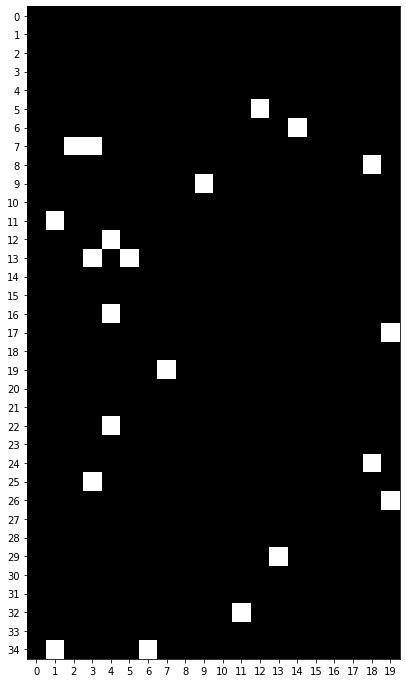

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(array, cmap='gray', vmin=0, vmax=1.)
plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0, 35, 1))
plot.show()

For problem 2, refer to TABLE IX of [1], the eaxt solution weight is indeed 7500 kg. (n=6, N =4)

Recall that the frst $n\times N$ elemnets of $z$ is $p_{ij}$, i.e. $z[i\times N+j]=p_{ij}$.

 if container $i$ occupies position $j$, $p_{ij}=1$, otherwise $p_{ij}=0$.